In [1]:
import numpy as np
from cvxpy import *
import datetime as dt
import statsmodels.api as sm
from numpy.linalg import inv
import os
import pandas as pd
from scipy import stats
import matplotlib
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from fredapi import Fred
fred = Fred('c83789a80592013f401a49faf02f01fe')
import warnings
warnings.filterwarnings("ignore")

C:\Users\Raman Gumber\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [15]:
'''
This is purposely commented out. Only Run this if you want to explicitly pull SBA data from the web. I highly suggest you
use the pickle I have attached to read in the data. This takes approximately 10 minutes to read via web.
'''

url1='http://imedia.sba.gov/vd/general/foia/FOIA%20-%207(a)(FY1991-FY1999).xlsx'
# loanLevelDfpre2000 = pd.read_excel(url1,usecols="F,H,L:Q,T:W,Z,AB,AD:AI")
url2='http://imedia.sba.gov/vd/general/foia/FOIA%20-%207(a)(FY2000-FY2009).xlsx'
url3='http://imedia.sba.gov/vd/general/foia/FOIA%20-%207(a)(FY2010-Present).xlsx'
# loanLevelDfPost2000Pre2009 = pd.read_excel(url2,usecols="F,H,L:Q,T:W,Z,AB,AD:AI")
# loanLevelDfPost2009= pd.read_excel(url3,usecols="F,H,L:Q,T:W,Z,AB,AD:AI")
# loanLevelDF = pd.concat([loanLevelDfpre2000,loanLevelDfPost2000Pre2009,loanLevelDfPost2009])
# loanLevelDF['OriginationVintage']=loanLevelDF.ApprovalDate.dt.to_period('M')



In [17]:
# loanLevelDF.to_pickle('loanLevelDF.pkl')

In [18]:

def wavg(group, avg_name, weight_name):
    """
    Parameters
    ----------
    group: DataFrame
     * DataFrame containing the weights and series to average
    avg_name: str
     * name of column that we want to average out by
    weight_name: str
     * name of column that we want to weight by when averaging
    
    Returns
    -------
    The weighted average of the series (avg_name) weighted by (weight_name)
    
    """
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()
    


def simple_amort_tbl(loan, apr, time):
    """
    Parameters
    ----------
    loan: float
     * Amount of loan in dollars
    apr: float
     * APR rate expressed in percentage
    time: int
     * Time in months
    
    Returns
    -------
    principalPayment: list
    interestPayment: list
    
    """
    rper = apr/12
    period = 0
    balance = loan
    payment=-np.pmt(rper, time, loan)
    principalPayment=[]
    interestPayment=[]
    while balance > 0:
        period += 1
        intamt = rper * balance
        paidamt = payment - intamt
        balance = balance - paidamt
        principalPayment.append(paidamt)
        interestPayment.append(intamt)
        if balance < payment:
            payment = balance + (rper*balance)
    return principalPayment,interestPayment

In [19]:

loanLevelDF['OriginationVintage']=loanLevelDF.ApprovalDate.dt.to_period('M') # Assign every loan to its vintage by month
loanLevelDF['ChargedOffMonth']=loanLevelDF.ChargeOffDate.dt.to_period('M') # Assign the month when a loan defaults

# A loan is assumed to be "Seasoned" halfway through its term to maturity
loanLevelDF['seasonMonth']=loanLevelDF['OriginationVintage']+(loanLevelDF['TermInMonths']/2).astype(int)
loanLevelDF.loc[loanLevelDF['seasonMonth']==loanLevelDF['OriginationVintage'],'seasonMonth']=loanLevelDF.loc[loanLevelDF['seasonMonth']==loanLevelDF['OriginationVintage'],'seasonMonth']+24

# Keep a seperate dataframe of loans that were charged off
ChgOffDF=loanLevelDF.loc[loanLevelDF['LoanStatus']=='CHGOFF'].copy(deep=True)
ChgOffDF['ChargedOffMonth']=ChgOffDF.ChargeOffDate.dt.to_period('M')

# Keep count of how much the loan had seasoned by when it got charged off
ChgOffDF['seasonedTime']=ChgOffDF['ChargedOffMonth']-ChgOffDF['OriginationVintage']
ChgOffDF.loc[ChgOffDF['TermInMonths']<ChgOffDF['seasonedTime'],'TermInMonths']=ChgOffDF.loc[ChgOffDF['TermInMonths']<ChgOffDF['seasonedTime'],'seasonedTime']

# Keep an indicator variable stating 1 if the loan at charge off was seasoned (time of charge off>.5*term length)
ChgOffDF['seasonedInd']=ChgOffDF['seasonedTime'].divide(ChgOffDF['TermInMonths'])>.5

[]

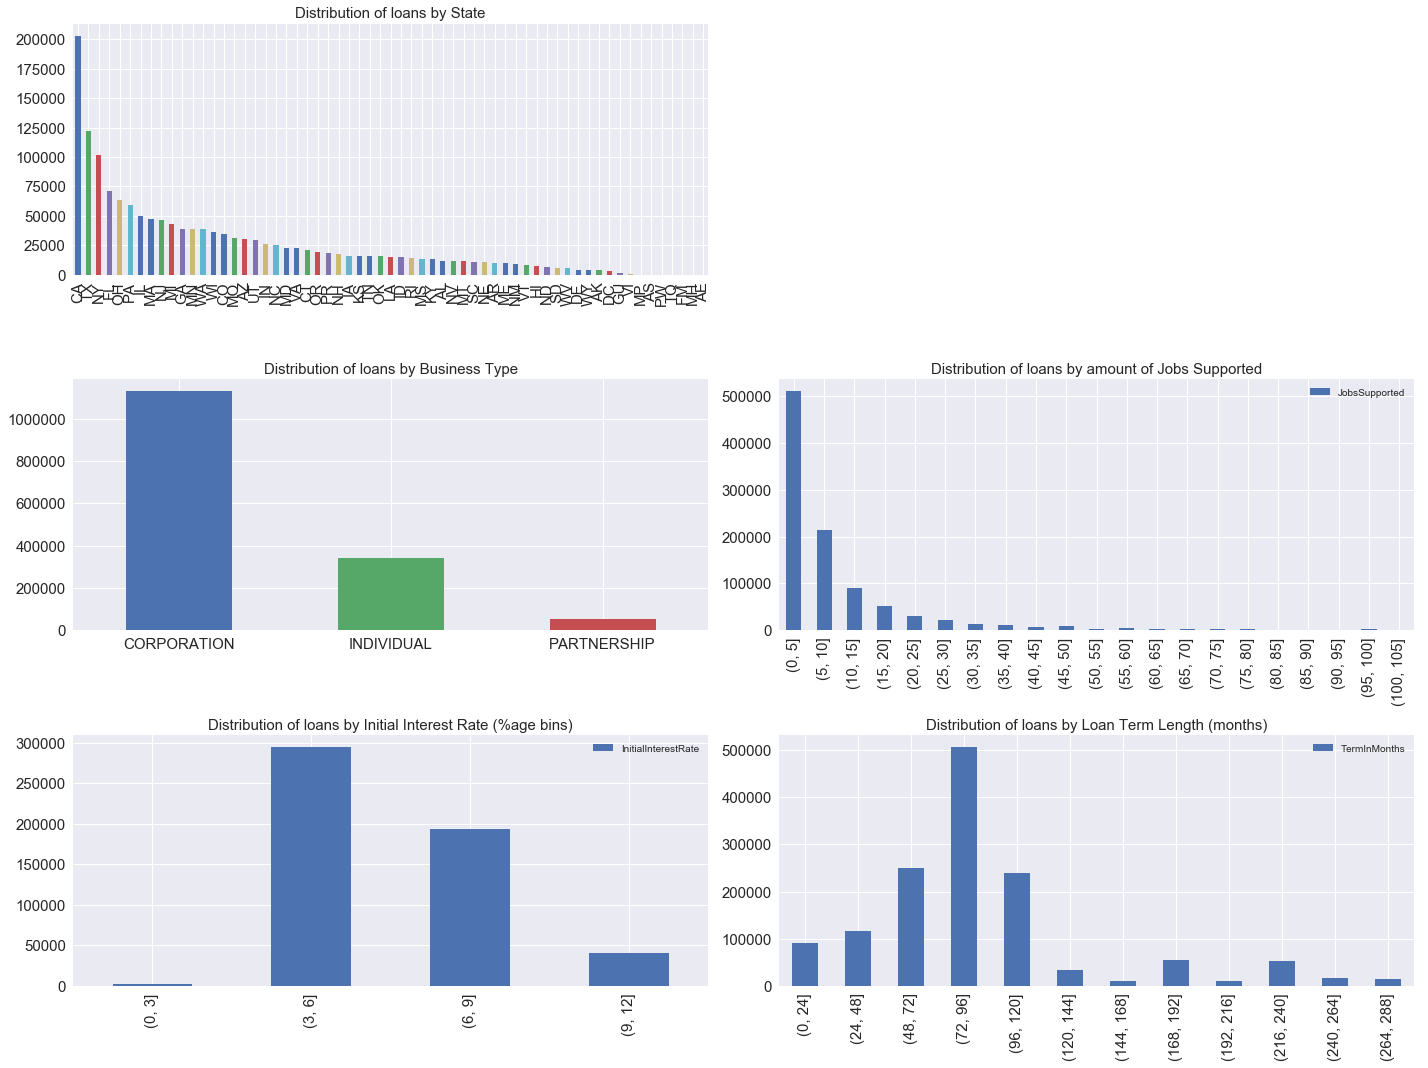

In [20]:
sns.set()
loanLevelDF['JobsSupported'].apply(lambda x: min(x,100))
fig,ax=plt.subplots(3,2,figsize=(20,15))
loanLevelDF['BorrState'].value_counts().plot(kind='bar',ax=ax[0,0])


loanLevelDF['BusinessType'].value_counts().plot(kind='bar',ax=ax[1,0])

bins = np.arange(0,110, 5)
hist = pd.cut(loanLevelDF['JobsSupported'], bins).value_counts()
hist.sort_index().to_frame().plot(kind='bar',ax=ax[1,1])
bins = np.arange(0,15, 3)
hist = pd.cut(loanLevelDF['InitialInterestRate'], bins).value_counts()
hist.sort_index().to_frame().plot(kind='bar',ax=ax[2,0])


bins = np.arange(0,300, 24)
hist = pd.cut(loanLevelDF['TermInMonths'], bins).value_counts()
hist.sort_index().to_frame().plot(kind='bar',ax=ax[2,1])
ax[0, 1].axis('off')

ax[0,0].set_title('Distribution of loans by State')
ax[1,0].set_title('Distribution of loans by Business Type')
ax[1,1].set_title('Distribution of loans by amount of Jobs Supported')
ax[2,0].set_title('Distribution of loans by Initial Interest Rate (%age bins)')
ax[2,1].set_title('Distribution of loans by Loan Term Length (months)')
for tick in ax[1,0].get_xticklabels():
        tick.set_rotation(0)
for axes in [ax[0,0],ax[1,0],ax[1,1],ax[2,0],ax[2,1]]:
    for item in ([axes.title, axes.xaxis.label, axes.yaxis.label] +
                 axes.get_xticklabels() + axes.get_yticklabels()):
        item.set_fontsize(15)

plt.tight_layout()
plt.plot()


[]

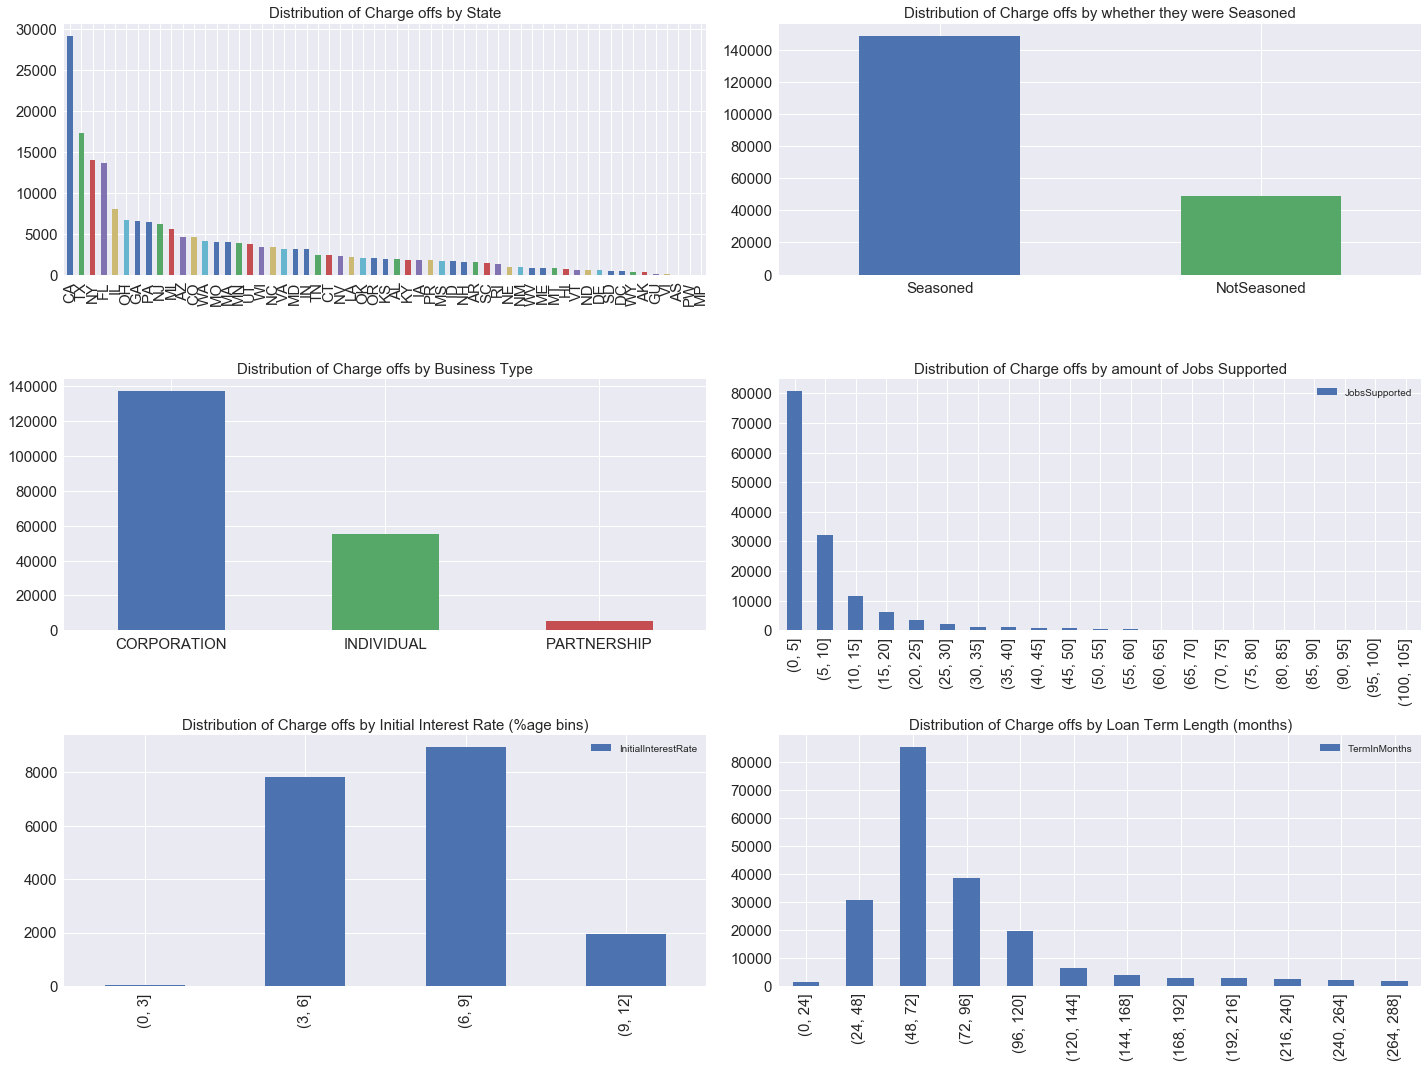

In [21]:
sns.set()

fig,ax=plt.subplots(3,2,figsize=(20,15))
majorStates=list(ChgOffDF['BorrState'].value_counts()[:10].index)
ChgOffDF['BorrState'].value_counts().plot(kind='bar',ax=ax[0,0])
df=ChgOffDF['seasonedInd'].value_counts()
df.index=['Seasoned','NotSeasoned']
df.plot(kind='bar',ax=ax[0,1])
ChgOffDF['BusinessType'].value_counts().plot(kind='bar',ax=ax[1,0])
bins = np.arange(0,110, 5)
hist = pd.cut(ChgOffDF['JobsSupported'], bins).value_counts()
hist.sort_index().to_frame().plot(kind='bar',ax=ax[1,1])

bins = np.arange(0,15, 3)
hist = pd.cut(ChgOffDF['InitialInterestRate'], bins).value_counts()
hist.sort_index().to_frame().plot(kind='bar',ax=ax[2,0])


bins = np.arange(0,300, 24)
hist = pd.cut(ChgOffDF['TermInMonths'], bins).value_counts()
hist.sort_index().to_frame().plot(kind='bar',ax=ax[2,1])
ax[0,0].set_title('Distribution of Charge offs by State')
ax[0,1].set_title('Distribution of Charge offs by whether they were Seasoned')
ax[1,0].set_title('Distribution of Charge offs by Business Type')
ax[1,1].set_title('Distribution of Charge offs by amount of Jobs Supported')
ax[2,0].set_title('Distribution of Charge offs by Initial Interest Rate (%age bins)')
ax[2,1].set_title('Distribution of Charge offs by Loan Term Length (months)')
for tick in ax[1,0].get_xticklabels():
        tick.set_rotation(0)
for tick in ax[0,1].get_xticklabels():
        tick.set_rotation(0)
for axes in [ax[0,0],ax[0,1],ax[1,0],ax[1,1],ax[2,0],ax[2,1]]:
    for item in ([axes.title, axes.xaxis.label, axes.yaxis.label] +
                 axes.get_xticklabels() + axes.get_yticklabels()):
        item.set_fontsize(15)

plt.tight_layout()
# plt.savefig('chargeOffDistribution.png')
plt.plot()

#### OriginationVintageDF: dataframe that keeps count of loans originated by vintage (on a monthly vintage basis)

In [22]:
'''
OriginationVintageDF: dataframe that keeps count of loans originated by vintage (on a monthly vintage basis)
--------------------
Columns:
    GrossApproval: Sum of loan principal originated by monthly vintage
    SBAGuaranteedApproval: Sum of loan principal originated by monthly vintage guaranteed by SBA
    CORPORATION: Count of loans originated with business Type as CORPORATION that vintage
    INDIVIDUAL: Count of loans originated with business Type as INDIVIDUAL that vintage
    PARTNERSHIP: Count of loans originated with business Type as PARTNERSHIP that vintage
    TermInMonths: Weighted Average of Term Length of loans originated (weighted by GrossApproval Amount)
    InitialInterestRate: Weighted Average of InitialInterestRate of loans originated (weighted by GrossApproval Amount)
    JobsSupported: Weighted Average of JobsSupported of loans originated (weighted by GrossApproval Amount)
    seasonedCount: count of loans seasoning every vintage (i.e how many loans have crossed the half way point of their term length)
    MPRIME: Bank Prime Rate for that month as taken from the FED (seperate data source)
    PP: Amount of Principal of loans being paid back that month
    IP: Amount of Interest on loans being paid thant month
    CORPORATIONCount: Count of loans in the pool that are active (i.e not fully amortized) that are of CORPORATION Type
    INDIVIDUALCount: Count of loans in the pool that are active (i.e not fully amortized) that are of INDIVIDUAL Type
    PARTNERSHIPCount: Count of loans in the pool that are active (i.e not fully amortized) that are of PARTNERSHIP Type
    LoanPortfolioAmortized: The amortized value of the loan pool (taking into account the principal repaid till date)
    
    ***We build our own amoritization schedule of the loan pool assuming payments are done at the end of month. This derives our PP,IP
    and LoanPortfolioAmortized Values. LoanPortfolioAmortized is essentially the PV of the Principal, Interest and Charged off Amounts 
    that are pending at the end of every month
    
    ***From 1991-2008 no InitialInterestRate Data was available, so instead we just took the Bank Prime Rate from the FEDs Website
    
'''

OriginationVintageDF=loanLevelDF.groupby(['OriginationVintage'])[["GrossApproval","SBAGuaranteedApproval"]].sum()
OriginationVintageDFcount=loanLevelDF.groupby(['OriginationVintage','BusinessType'])[["BusinessType"]].count().unstack(level=-1)
OriginationVintageDFcount.columns=OriginationVintageDFcount.columns.droplevel(level=0)
OriginationVintageDF=pd.concat([OriginationVintageDF, OriginationVintageDFcount], axis=1, sort=False)


OriginationVintageDF=OriginationVintageDF.join(loanLevelDF.groupby(['OriginationVintage']).apply(wavg, "TermInMonths", "GrossApproval").rename('TermInMonths'))
OriginationVintageDF=OriginationVintageDF.join(loanLevelDF.groupby(['OriginationVintage']).apply(wavg, "InitialInterestRate", "GrossApproval").rename('InitialInterestRate'))
OriginationVintageDF=OriginationVintageDF.join(loanLevelDF.groupby(['OriginationVintage']).apply(wavg, "JobsSupported", "GrossApproval").rename('JobsSupported'))
seasonedCount=loanLevelDF.groupby(['seasonMonth'])[["seasonMonth"]].count()
seasonedCount.columns=['seasonedCount']
OriginationVintageDF=OriginationVintageDF.join(seasonedCount)
OriginationVintageDF['seasonedCount']=OriginationVintageDF['seasonedCount'].fillna(0)
OriginationVintageDF['InitialInterestRate']=OriginationVintageDF['InitialInterestRate'].fillna(0)

s = fred.get_series('MPRIME', observation_start='1990-09-02', observation_end='2018-10-01')
primeRates=pd.DataFrame(s).reset_index()
primeRates.columns=['DATE','MPRIME']
primeRates['DATE']=primeRates['DATE'].dt.to_period('M')
primeRates=primeRates.set_index('DATE')
if 'MPRIME' in OriginationVintageDF.columns:
    OriginationVintageDF=OriginationVintageDF.drop('MPRIME',axis=1)
    
OriginationVintageDF=OriginationVintageDF.join(primeRates)
OriginationVintageDF.loc[OriginationVintageDF['InitialInterestRate']==0,'InitialInterestRate']=OriginationVintageDF.loc[OriginationVintageDF['InitialInterestRate']==0,'MPRIME']


OriginationVintageDF['PP']=0
OriginationVintageDF['IP']=0
OriginationVintageDF['CORPORATIONCount']=0
OriginationVintageDF['INDIVIDUALCount']=0
OriginationVintageDF['PARTNERSHIPCount']=0


OriginationVintageDF.head()
lenDF=len(OriginationVintageDF)
for i in range(lenDF-1):
    l=OriginationVintageDF.ix[i,'GrossApproval']
    a=OriginationVintageDF.ix[i,'InitialInterestRate']/100
    t=int(OriginationVintageDF.ix[i,'TermInMonths'])
    PP,IP=simple_amort_tbl(l, a, t)
    corp=OriginationVintageDF.ix[i,'CORPORATION']
    indiv=OriginationVintageDF.ix[i,'INDIVIDUAL']
    partner=OriginationVintageDF.ix[i,'PARTNERSHIP']

    fillLen=min(t,lenDF-i)
    corp=[corp]*fillLen
    OriginationVintageDF.ix[i:i+fillLen, 'PP']=OriginationVintageDF.ix[i:i+fillLen, 'PP']+PP[:fillLen]
    OriginationVintageDF.ix[i:i+fillLen, 'IP']=OriginationVintageDF.ix[i:i+fillLen, 'IP']+IP[:fillLen]
    OriginationVintageDF.ix[i:i+fillLen, 'CORPORATIONCount']=OriginationVintageDF.ix[i:i+fillLen, 'CORPORATIONCount']+corp
    OriginationVintageDF.ix[i:i+fillLen, 'INDIVIDUALCount']=OriginationVintageDF.ix[i:i+fillLen, 'INDIVIDUALCount']+indiv
    OriginationVintageDF.ix[i:i+fillLen, 'PARTNERSHIPCount']=OriginationVintageDF.ix[i:i+fillLen, 'PARTNERSHIPCount']+partner

OriginationVintageDF['LoanPortfolioAmortized']=OriginationVintageDF['GrossApproval'].cumsum()-OriginationVintageDF['PP'].cumsum()


[]

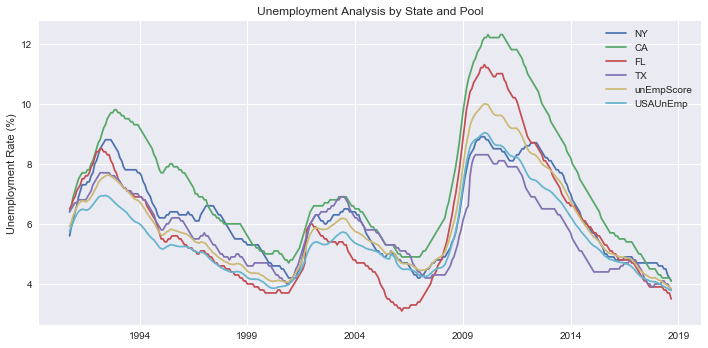

In [23]:
states=list(set(ChgOffDF['BorrState'])) # List of all states in our data
statesIn=[] # states for which we did find Unemployment data 
statesNotIn=[] # states for which we didn't find Unemployment data 
unempRates=[]
for i in states:
    ## find unemployment data from FRED
    try:
        unempRates.append(fred.get_series(i+"UR", observation_start='1990-09-02', observation_end='2018-10-01'))
        statesIn.append(i)
    except:
   
        statesNotIn.append(i)
    
unEmpDF=pd.concat(unempRates,axis=1) # DataFrame of unemployment rates by month and state
unEmpDF.columns=statesIn
unEmpDF['USA']=unEmpDF.mean(axis=1)

loanLevelDF['BorrStateTrans']=loanLevelDF['BorrState'].apply(lambda x: x if x in statesIn else 'USA')

## Helper DataFrame which groups the amount originated by state and month
StateStypePool=loanLevelDF.groupby(['OriginationVintage','BorrStateTrans'])[["GrossApproval"]].sum().unstack(level=-1).fillna(0)
StateStypePool.columns=StateStypePool.columns.droplevel(level=0)

## We aproximate the amount of loan value in our pool of loans at eveyr month by state then normalize it by 
## the amount of loans on book at every month end (we do not look at the amortized loan value, rather the full loan amount until it is taken off balance sheet)
## Hence we have a dataframe where by every month we have the proportion of loans in pool by state
StateTypePoolCum=pd.DataFrame(np.zeros(StateStypePool.shape))
StateTypePoolCum.index=StateStypePool.index
for i in range(lenDF-1):
    t=int(OriginationVintageDF.ix[i,'TermInMonths'])
    fillLen=min(t,lenDF-i)
    a=StateStypePool.iloc[i]
    StateTypePoolCum.iloc[i:i+fillLen]=StateTypePoolCum.iloc[i:i+fillLen]+np.tile(a,(fillLen,1))
StateTypePoolCum.index=list(map(lambda x: x.to_timestamp(),StateTypePoolCum.index))
StateTypePoolCum.columns=StateStypePool.columns
sumAcross=StateTypePoolCum.sum(axis=1)
StateTypePoolCum=StateTypePoolCum.divide(sumAcross,axis=0)


# We cross multiply loan proportion by state with the unemployment score by state every month to receive a unemploymnet score for our pool of loans every month

fig,ax=plt.subplots(1,1,figsize=(10,5))
unEmpDF=unEmpDF.loc[StateTypePoolCum.index]
unEmpDF[['NY','CA','FL','TX']].plot(ax=ax)
unEmpDF=pd.concat([(StateTypePoolCum*unEmpDF).sum(axis=1),unEmpDF['USA']],axis=1)
unEmpDF.columns=['unEmpScore','USAUnEmp']
unEmpDF.round(2).head()
unEmpDF[['unEmpScore','USAUnEmp']].plot(ax=ax)
ax.set_title('Unemployment Analysis by State and Pool')
ax.set_ylabel('Unemployment Rate (%)')
plt.tight_layout()
plt.plot()
# plt.savefig('Unemployment.png')

In [24]:
'''
ChargedOffVintageDF: dataframe that keeps count of loans charged off by month
--------------------
Columns:
    GrossApprovalChargedOff: Sum of loan principal (Gross Approval) of loans by month (not neccesarrily equal to the amount of charge off)
    SBAGuaranteedApprovalChargedOff: Sum of loan principal charged off by month guaranteed by SBA
    GrossChargeOffAmount: Amount charged off every month
    CORPORATIONChargedOff: Count of loans charged off with business Type as CORPORATION that month
    INDIVIDUALChargedOff: Count of loans charged off with business Type as INDIVIDUAL that month
    PARTNERSHIPChargedOff: Count of loans charged off with business Type as PARTNERSHIP that month
    TermInMonthsChargedOff: Weighted Average of Term Length of loans charged off (weighted by GrossChargeOffAmount Amount)
    InitialInterestRateChargedOff: Weighted Average of InitialInterestRate of loans charged off (weighted by GrossChargeOffAmount Amount)
    seasonedTime: Weighted Average of time the loans were into their lives at the time of charge off(weighted by GrossChargeOffAmount)
    JobsSupportedChargedOff: Weighted Average of JobsSupported of loans charged off (weighted by GrossChargeOffAmount Amount)
'''


ChargedOffVintageDF=ChgOffDF.groupby(['ChargedOffMonth'])[["GrossApproval","SBAGuaranteedApproval","GrossChargeOffAmount"]].sum()
ChargedOffVintageDFcount=ChgOffDF.groupby(['ChargedOffMonth','BusinessType'])[["BusinessType"]].count().unstack(level=-1)
ChargedOffVintageDFcount.columns=ChargedOffVintageDFcount.columns.droplevel(level=0)
ChargedOffVintageDF=pd.concat([ChargedOffVintageDF, ChargedOffVintageDFcount], axis=1, sort=False)

ChgOffDF['BorrStateType']=ChgOffDF['BorrState'].apply(lambda x: 'MajorState' if x in majorStates else 'OtherState')
ChargedOffVintageDFcount=ChgOffDF.groupby(['ChargedOffMonth','BorrStateType'])[["BorrStateType"]].count().unstack(level=-1).fillna(0)
ChargedOffVintageDFcount.columns=ChargedOffVintageDFcount.columns.droplevel(level=0)
ChargedOffVintageDF=pd.concat([ChargedOffVintageDF, ChargedOffVintageDFcount], axis=1, sort=False)

ChargedOffVintageDF=ChargedOffVintageDF.join(ChgOffDF.groupby(['ChargedOffMonth']).apply(wavg, "TermInMonths", "GrossChargeOffAmount").rename('TermInMonths'))
ChargedOffVintageDF=ChargedOffVintageDF.join(ChgOffDF.groupby(['ChargedOffMonth']).apply(wavg, "InitialInterestRate", "GrossChargeOffAmount").rename('InitialInterestRate'))
ChargedOffVintageDF=ChargedOffVintageDF.join(ChgOffDF.groupby(['ChargedOffMonth']).apply(wavg, "seasonedTime", "GrossChargeOffAmount").rename('seasonedTime'))
ChargedOffVintageDF=ChargedOffVintageDF.join(ChgOffDF.groupby(['ChargedOffMonth']).apply(wavg, "seasonedInd", "GrossChargeOffAmount").rename('seasonedChargedOffPool'))
ChargedOffVintageDF=ChargedOffVintageDF.join(ChgOffDF.groupby(['ChargedOffMonth']).apply(wavg, "JobsSupported", "GrossChargeOffAmount").rename('JobsSupported'))
ChargedOffVintageDF=ChargedOffVintageDF[ChargedOffVintageDF.index<'2018-10']

if 'MPRIME' in ChargedOffVintageDF.columns:
    ChargedOffVintageDF=ChargedOffVintageDF.drop('MPRIME',axis=1)
    
ChargedOffVintageDF=ChargedOffVintageDF.join(primeRates)
ChargedOffVintageDF.loc[ChargedOffVintageDF['InitialInterestRate']==0,'InitialInterestRate']=ChargedOffVintageDF.loc[ChargedOffVintageDF['InitialInterestRate']==0,'MPRIME']
commonColslist=(set(OriginationVintageDF.columns).intersection(set(ChargedOffVintageDF.columns)))
ChargedOffVintageDF.columns=list(map(lambda x: x+"ChargedOff" if x in commonColslist else x,ChargedOffVintageDF.columns))

ChargedOffVintageDF.head()

,GrossApprovalChargedOff,SBAGuaranteedApprovalChargedOff,GrossChargeOffAmount,CORPORATIONChargedOff,INDIVIDUALChargedOff,PARTNERSHIPChargedOff,MajorState,OtherState,TermInMonthsChargedOff,InitialInterestRateChargedOff,seasonedTime,seasonedChargedOffPool,JobsSupportedChargedOff,MPRIMEChargedOff
ChargedOffMonth,,,,,,,,,,,,,,
1991-10,30000,27000,26488,1.0,1.0,NaN,1.0,1.0,72.249471,8.00,10.017970,0.000000,0.0,8.00
1991-11,12500,11250,12873,1.0,NaN,NaN,0.0,1.0,79.000000,7.58,13.000000,0.000000,0.0,7.58
1991-12,84000,69650,84793,2.0,NaN,1.0,0.0,3.0,50.995495,7.21,12.238310,0.412770,0.0,7.21
1992-01,100000,87900,67564,1.0,NaN,NaN,1.0,0.0,55.000000,6.50,15.000000,0.000000,0.0,6.50
1992-03,160000,139000,134972,2.0,1.0,NaN,2.0,1.0,59.289623,6.50,16.555463,0.088907,0.0,6.50


#### Loss Rate Modelling
We define the Loss Rate as follows:

$rollLossRate=\frac{RollingSumOfChargedOffAmount}{RollingMeanOfAmortizedLoanPortfolioAmount}$

We finally look at the YoY (year over year) change in the loss rate (as the so called "increase" or "decrease" of loss rate of the pool over time): $rollLossRateDiff=rollLossRate_t-rollLossRate_{t-12}$

We further plot the rollLossRate and rollLossRateDiff

[]

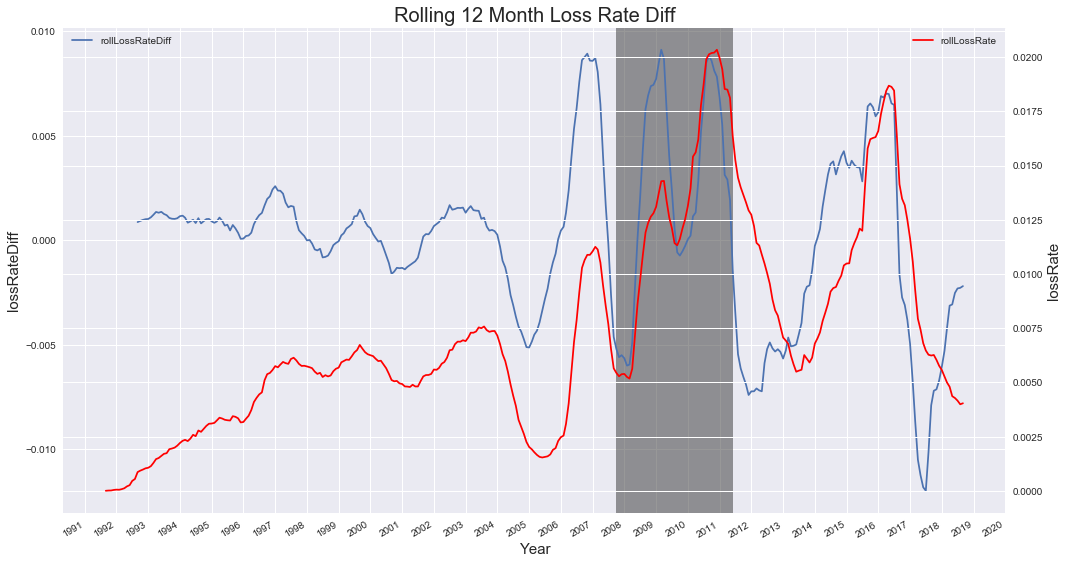

In [25]:
'''
summaryDF: dataframe that summarizes all our features for loan level data by month. Includes all the features and the loss rate we will buils out
--------------------
Columns:
        Includes All Columns in OriginationVintageDF ChargedOffVintageDF
        
        rollSumChargeOff: Rolling 12 month sum of amount charged off
        rollAvgPortfolioAmortized: Rolling 12 month mean of LoanPortfolioAmortized
        rollLossRate:rollSumChargeOff/rollAvgPortfolioAmortized
        rollLossRateDiff: YoY (Year on Year) difference of rollLossRate ~ THIS IS WHAT WE ARE INTERESTED IN
        unEmpScore: enemployment score of the loan pool that is still active every month
        unEmpScoreDiff: change of unEmpScore MoM (Month on Month)
        seasonedCount:Count of Loans that are seasoned
        LoansInPool:Total number of loans alive in pool
        seasonedRatioPool: seasonedCount/LoansInPool
        CorporationRatio: Loans in Pool by Corporation type/LoansInPool
        IndividualRatio: Loans in Pool by Individual type/LoansInPool
        PartnerShipRatio: Loans in Pool by PartnerShip type/LoansInPool
'''
summaryDF=OriginationVintageDF.join(ChargedOffVintageDF).fillna(0)
summaryDF['rollSumChargeOff']=summaryDF['GrossChargeOffAmount'].rolling(12).sum()
summaryDF['rollAvgPortfolioAmortized']=summaryDF['LoanPortfolioAmortized'].rolling(12).mean()
summaryDF['rollLossRate']=summaryDF['rollSumChargeOff']/summaryDF['rollAvgPortfolioAmortized']
summaryDF.index=summaryDF.index.to_timestamp()
summaryDF=summaryDF.drop(['CORPORATION','INDIVIDUAL','PARTNERSHIP'],axis=1)
summaryDF['rollLossRateDiff']=summaryDF['rollLossRate'].diff(12)
summaryDF['unEmpScore']=unEmpDF['unEmpScore']
summaryDF['unEmpScoreDiff']=summaryDF['unEmpScore'].diff()

summaryDF['ChargedOffLoans']=summaryDF['CORPORATIONChargedOff']+summaryDF['INDIVIDUALChargedOff']+summaryDF['PARTNERSHIPChargedOff']
summaryDF['LoansInPool']=summaryDF['CORPORATIONCount']+summaryDF['INDIVIDUALCount']+summaryDF['PARTNERSHIPCount']
summaryDF['seasonedRatioPool']=summaryDF['seasonedCount']/summaryDF['LoansInPool']
summaryDF['CorporationRatio']=summaryDF['CORPORATIONCount']/summaryDF['LoansInPool']
summaryDF['IndividualRatio']=summaryDF['INDIVIDUALCount']/summaryDF['LoansInPool']
summaryDF['PartnerShipRatio']=summaryDF['PARTNERSHIPCount']/summaryDF['LoansInPool']

sns.set()
ax=summaryDF['rollLossRateDiff'].plot(figsize=(15,8),x_compat=True,label='rollLossRateDiff')

start, end = ax.get_xlim()

summaryDF.head()
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.set_ylabel('lossRateDiff',size=15)
ax.set_xlabel('Year',size=15)
ax.set_title('Rolling 12 Month Loss Rate Diff' ,size=20)

ax.axvspan('2007-10-01', '2011-06-01', facecolor='0.2', alpha=0.5)
ax.legend(loc=2)
ax2 = ax.twinx()
summaryDF['rollLossRate'].plot(figsize=(15,8),x_compat=True,color='r',ax=ax2,label='rollLossRate')
ax2.legend()

ax2.xaxis.set_major_locator(years)
ax2.xaxis.set_major_formatter(yearsFmt)
ax2.xaxis.set_minor_locator(months)
ax2.set_ylabel('lossRate',size=15)
ax2.set_xlabel('Year',size=15)

plt.tight_layout()
# plt.savefig('LossRateRolling.png')
plt.plot()

[]

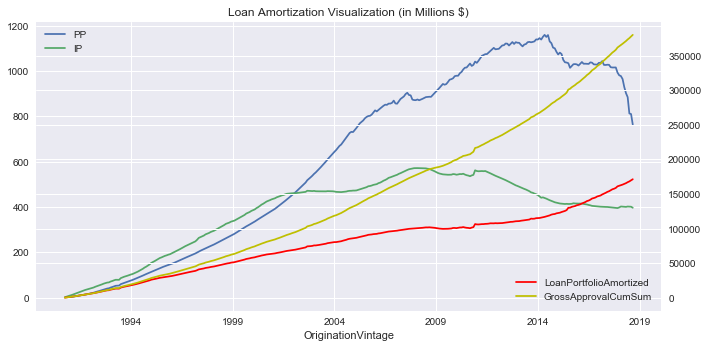

In [26]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
(summaryDF[['PP','IP']]/1000000).round(2).plot(ax=ax)
ax2 = ax.twinx()
(summaryDF[['LoanPortfolioAmortized']]/1000000).round(2).plot(ax=ax2,color='r')
(summaryDF['GrossApproval'].cumsum()/1000000).round(2).plot(ax=ax2,color='y',label='GrossApprovalCumSum')
ax.legend(loc=2)
ax2.legend(loc=4)
ax.set_title('Loan Amortization Visualization (in Millions $)')
plt.tight_layout()
# plt.savefig('LoanAmortizationVisualization.png')
plt.plot()

#### We define a recession period of 2007-10-01:2011-06-01 and look at the correlations between several features and the rollLossRateDiff


[]

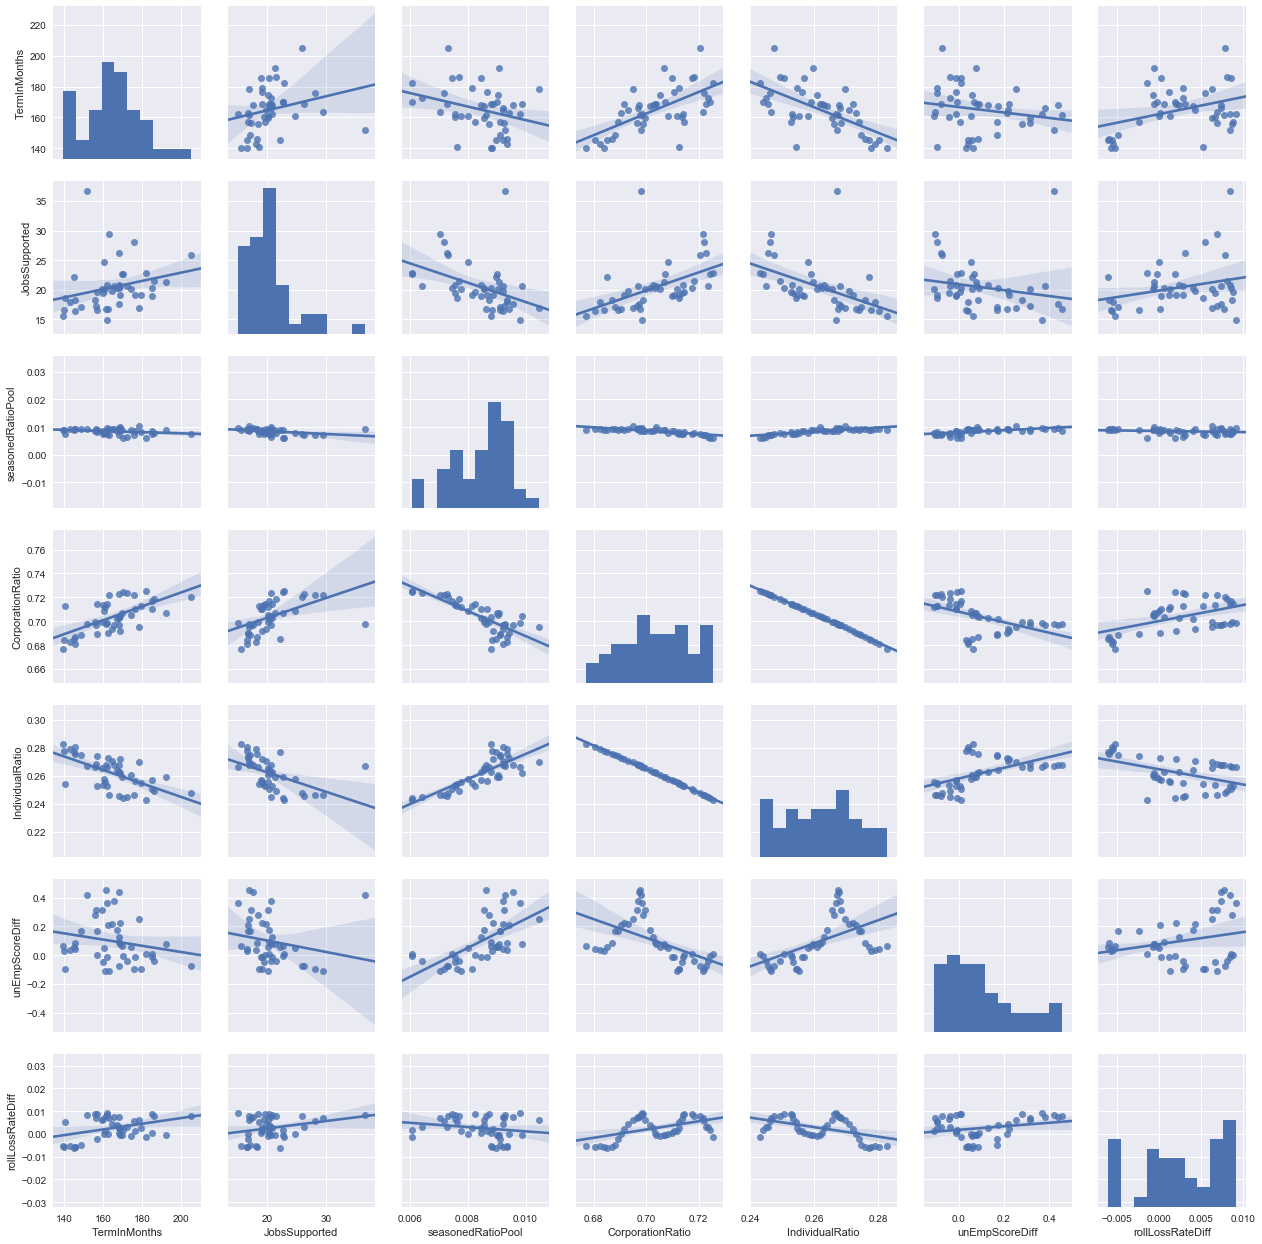

In [27]:
colsUse=['TermInMonths','JobsSupported','seasonedRatioPool','CorporationRatio','IndividualRatio','unEmpScoreDiff','rollLossRateDiff']
recessionTypeDF=pd.concat([summaryDF.loc['2007-10-01':'2011-06-01']])[colsUse]
sns.pairplot(recessionTypeDF,kind="reg")
plt.plot()


#### We define a Non Recession period of 2002-01-01:2007-06-01 and look at the correlations between several features and the rollLossRateDiff


[]

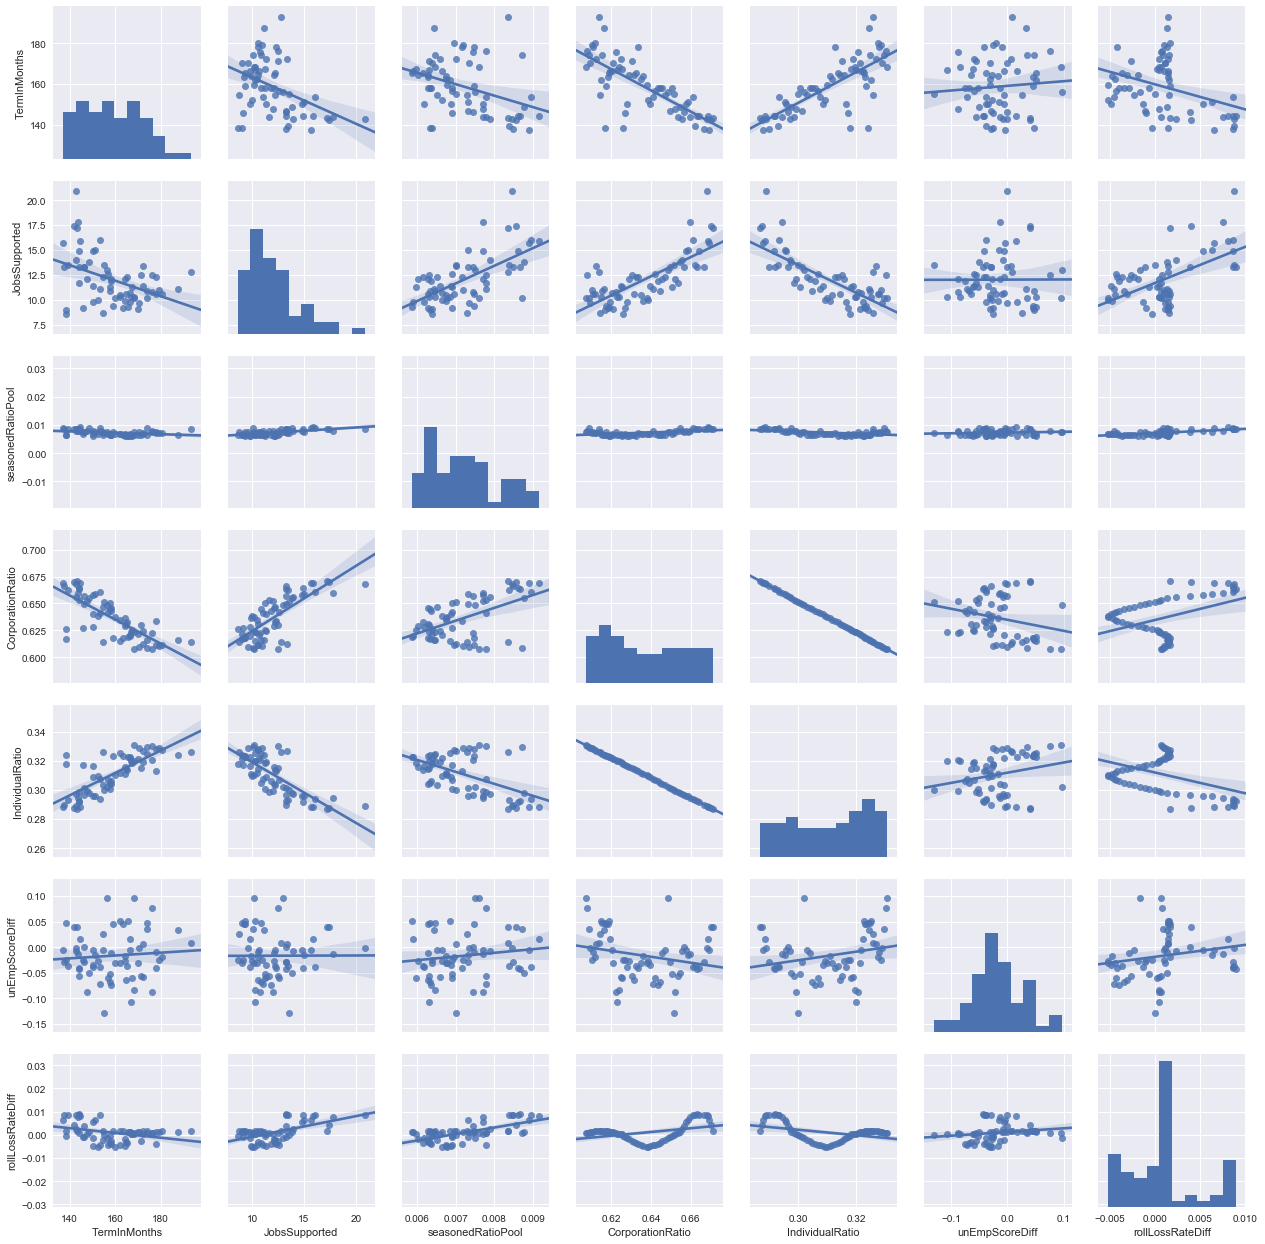

In [28]:
notRecessionTypeDF=pd.concat([summaryDF.loc['2002-01-01':'2007-06-01']])[colsUse]
sns.pairplot(notRecessionTypeDF,kind="reg")
plt.plot()


                            OLS Regression Results                            
Dep. Variable:       rollLossRateDiff   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     17.12
Date:                Fri, 01 Feb 2019   Prob (F-statistic):           1.42e-09
Time:                        22:11:15   Log-Likelihood:                 199.93
No. Observations:                  45   AIC:                            -387.9
Df Residuals:                      39   BIC:                            -377.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
CorporationRatio      0.1389      0.02

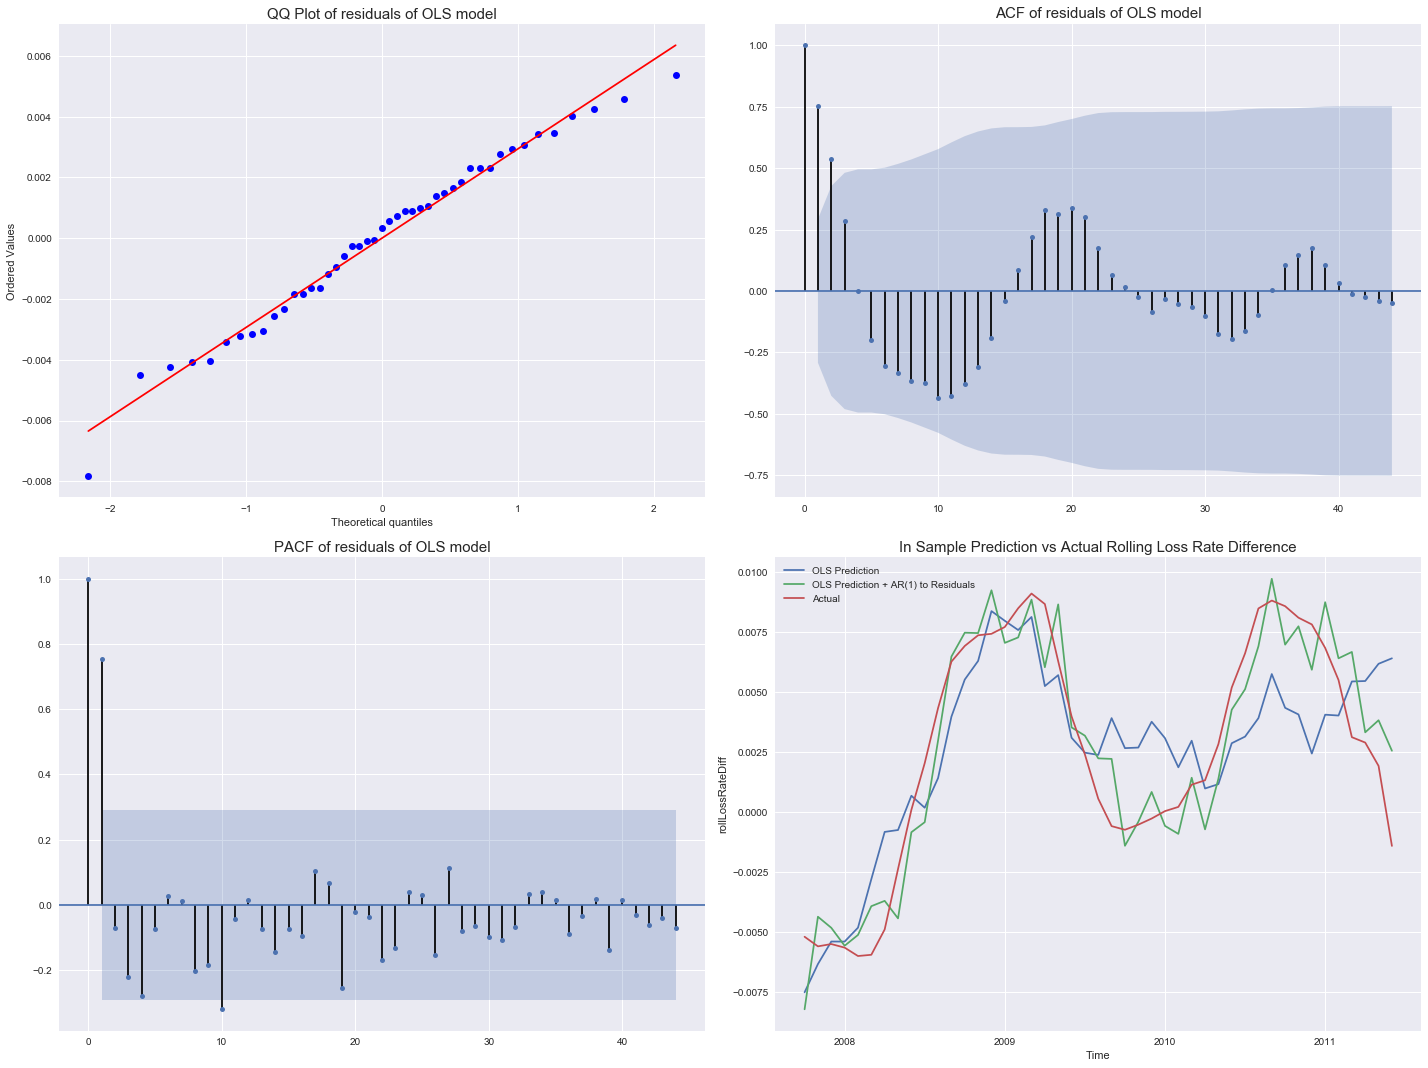

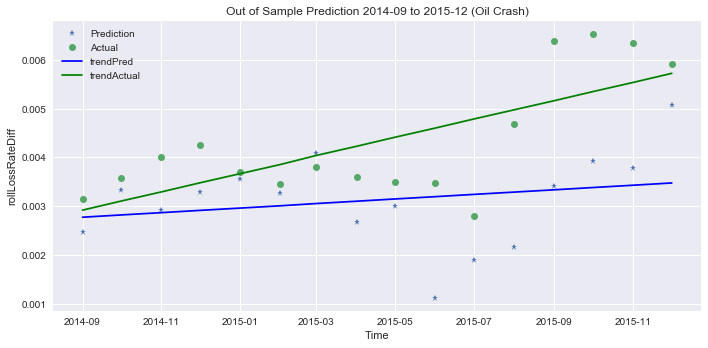

In [29]:
from statsmodels.graphics.tsaplots import plot_acf ,plot_pacf
from statsmodels.stats.stattools import durbin_watson
import pylab 
import scipy.stats as stats
'''
We train an OLS model to predict the rollLossRateDiff on the recession period where the features are:
    CorporationRatio
    IndividualRatio
    unEmpScoreDiff
    seasonedRatioPool
    JobsSupported
    TermInMonths
    
We look at OLS results. We look the Shapiro Wilk test to ensure normality of errors, and the QQ plot of errors.

We look at the Durbin-Watson test to see if there is autocorrelation in errors, which we correct for by fitting an AR model to the errors
The specification of the AR model is observed by runing the ACF and PACF on the errors by OLS

We then predict in-sample (Recession Period) rollLossRateDiff with just OLS parameters and then refine the prediction with AR(1) fitted into residuals
'''
paramsToCheck=['CorporationRatio','IndividualRatio','unEmpScoreDiff','seasonedRatioPool','JobsSupported','TermInMonths']
trainDF=pd.concat([summaryDF.loc['2007-10-01':'2011-06-01']])[colsUse]

X=trainDF[paramsToCheck]
Y=trainDF['rollLossRateDiff']

model = sm.OLS(Y,X)
results = model.fit()
results.resid
    
# Print OLS Result Summary
print(results.summary())
print()
fig,ax=plt.subplots(2,2,figsize=(20,15))


SW=stats.shapiro(results.resid)
print('P Val from Shapiro Wilk Test: {0:1.2f}'.format(SW[1]))
print()
if SW[1]>.05:
    print("Since SW P-Val >.05, errors are normally distributed")
    print()
else:
    print("Since SW P-Val <.05, errors are not normally distributed")
    print()
    
DW=durbin_watson(results.resid)
print("Durbin-Watson Stat: {0:1.2f}".format(DW))
print()
if DW <1.5:
    print('Positive Autocorrelation in residuals, hence we try fitting AR Model')
    print()
elif DW>3:
    print('Negative Autocorrelation in residuals, hence we try fitting AR Model')
    print()
else:
    print('No Autocorrelation in residuals')
    print()

stats.probplot(results.resid, dist="norm", plot=ax[0,0])


plot_acf(results.resid,ax=ax[0,1])
plot_pacf(results.resid,ax=ax[1,0])



arma_mod10 = sm.tsa.ARMA(results.resid, (1,0)).fit()

inSample=pd.concat([results.predict(X),results.predict(X)+arma_mod10.predict(),Y],axis=1)
inSample.columns=['OLS Prediction','OLS Prediction + AR(1) to Residuals','Actual']
inSample.plot(ax=ax[1,1])
ax[1,1].set_title('In Sample Prediction vs Actual Rolling Loss Rate Difference',size=15)
ax[1,1].set_ylabel('rollLossRateDiff')
ax[1,1].set_xlabel('Time')
ax[0,0].set_title('QQ Plot of residuals of OLS model',size=15)
ax[0,1].set_title('ACF of residuals of OLS model',size=15)
ax[1,0].set_title('PACF of residuals of OLS model',size=15)


'''
We have essentially trained a model on small but for sure a period that suffered a recession, and not just any recession, one which was credit related.

We can try to use this OLS on another Out Sample Time Series data that we think mimics recession time. The closest guess is 2014-09 to 2015-12.
This was a period of time when the oil price took a huge hit and we actually do see a spike in rollLossRateDiff and rollLossRate during that period.

We however should note that the Oil Crash of 2015 still doesn't mimic the recession as it did not come with a spike in credit risk as the 2008 Great Recession did.
Nevertheless, the results of our prediction and actual values of rollLossRateDiff are shown below as well.
'''
TestDF=pd.concat([summaryDF.loc['2014-09-01':'2015-12-31']])[['TermInMonths','JobsSupported','seasonedRatioPool','InitialInterestRate','CorporationRatio','IndividualRatio','rollLossRateDiff','unEmpScore','unEmpScoreDiff']]


Xos=TestDF[paramsToCheck]
Yos=TestDF['rollLossRateDiff']

def errorARPred(params,error):
    """
    Parameters
    ----------
    params: list
     * list or array of parameters for AR(1) model
    error: float
     * current error

    Returns
    -------
    prediction of the next error as per AR(1)
    """
    const=params[0]
    phi=params[1]
    nextError=const+phi*error
    return nextError
    
error=0
preds=[]
for i in range(len(Xos)):
    nextError=errorARPred(params=list(arma_mod10.params),error=error)
    pred=results.predict(list(Xos.iloc[i]))[0]+nextError
    error=Yos.iloc[i]-pred
    
    preds.append(pred)
plt.tight_layout()
plt.savefig('OLSResults.png')
plt.show()



outSample=pd.DataFrame(Yos.copy(deep=True))
outSample.columns=['Actual']
outSample['Prediction']=preds

plt.figure(figsize=(10,5))
plt.plot(outSample['Prediction'],'*',label='Prediction')
plt.plot(outSample['Actual'],'o',label='Actual')
lenUse=len(outSample)
xi = np.arange(0,lenUse)
A = np.array([ xi, np.ones(lenUse)])
y = outSample['Prediction']

slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept
outSample['trendPred']=line
plt.plot(outSample['trendPred'],'b-')

y = outSample['Actual']

slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
line = slope*xi+intercept
outSample['trendActual']=line
plt.plot(outSample['trendActual'],'g-')
plt.ylabel('rollLossRateDiff')
plt.xlabel('Time')
plt.title('Out of Sample Prediction 2014-09 to 2015-12 (Oil Crash)')
plt.legend()
plt.tight_layout()
plt.savefig('outofSampleOilCrashEstimate.png')
